In [109]:
import os
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import langid

In [2]:
pd.set_option("display.max_columns",  None)
pd.set_option("display.max_rows", None)

In [3]:
listings = pd.read_csv("data" + os.sep + "listings.csv")
listings_detail = pd.read_csv("data" + os.sep + "listings_detail.csv")

/home/yangsi/anaconda3/envs/tf/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3044: DtypeWarning: Columns (43,61,62,95) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### 数据预处理 -- 格式清洗

In [4]:
categorical_col = ["host_response_time",
                  "property_type", "room_type","bed_type",
                  "cancellation_policy"]

In [5]:
date_col = ["last_scraped", "host_since", "calendar_last_scraped",
            "first_review", "last_review"]

boolean_col = ["is_location_exact", 
               "host_is_superhost", "host_has_profile_pic",
               "host_identity_verified",
               "has_availability",
               "requires_license", 
               "instant_bookable", "is_business_travel_ready",
               "require_guest_profile_picture",
               "require_guest_phone_verification"]

int_col = ["zipcode"]

percent_col = ["host_response_rate"]

price_col = ["price", "weekly_price", "monthly_price", 
             "security_deposit", "cleaning_fee", "extra_people"]

# 该字段为一个list，包括host确认时的所有方式
list_col = ["host_verifications"]


In [6]:
def str2boolean(ch):
    if ch == "t":
        return True
    elif ch == "f":
        return False
    elif df.isnull(ch):
        return ch
    else:
        print("Unexpected value catched ", ch)
        return ch

def str2int(x):
    if pd.isnull(x):
        return x
    try:
        if isinstance (x, float):
            return int(x)
        elif isinstance(x, str):
            x = x.replace(" ", "")
            x = x.split(".")[0]
            return int(x)
    except:
        print("Unexpected value catched ", x)
        return np.nan

def str2percent(s):
    if pd.isnull(s):
        return s
    elif s[-1] == "%":
        return int(s[:-1])/100
    else:
        print("Unexpected value catched ", s)
        return s

def str2price(string):
    if pd.isnull(string):
        return string
    elif string[0] == "$":
        return float(string[1:].replace(",", ""))
    else:
        print("unexpected value catched ", string)
        return string

# 某列column的元素为list，list内部的元素有限N个，创建N列，若每行具备则置1，否则置0
def list2onehot(col):
    listings_detail[col] = listings_detail[col].map(lambda v: eval(v))
    alist = []
    for l in listings_detail[col].values:
        alist.extend(l)
    alist = list(set(alist))
    print("There are possible values in the list ", alist)
    
    for item in alist:
        listings_detail[item] = listings_detail[col].apply(lambda d: 1 if item in d else 0) 

# 将calendar update 字符串形式量化为具体数值
def update2int(up_str):
    if up_str == "never":
        return -1
    elif up_str == "today":
        return 0
    elif up_str == "yesterday":
        return 1
    
    up = up_str.split(" ")
    if "day" in up[1] :
        unit = 1
    elif "week" in up[1]:
        unit = 7
    elif "month" in up[1]:
        unit = 30
    else:
        print("unexpected value catched ", up)
        return up_str
    if up[0] == "a" or up[0] == "one":
        freq = 1
    else:
        freq = int(up[0])
    
    return freq*unit

def drop_useless_cols():
    # 查看所有值均为nan的column，或者大部分值均为nan的column，则该为无用column
    global listings_detail
    count = listings_detail.isna().sum()

    listing_size = listings_detail.shape[0]
    useless_col = []
    for key,value in count.items():
        if value == 0:
            del count[key]
        if value >= listing_size * 0.99:
            useless_col.append(key)
    
    print("useless columns found ", useless_col)
    listings_detail = listings_detail.drop(columns = useless_col, axis = 1)

In [7]:
def preprocess_listings_detail():
    
    print("preprocessing datetime related column ...")
    for col in date_col:
        listings_detail[col] = listings_detail[col].map(lambda d: datetime.datetime.strptime(d, "%Y-%m-%d") if not pd.isnull(d) else d)

    print("preprocessing boolean related column ...")
    for col in boolean_col:
        listings_detail[col] = listings_detail[col].map(str2boolean)
    
    print("preprocessing int related column ...")
    for col in int_col:
        listings_detail[col] = listings_detail[col].map(str2int)
    
    print("preprocessing percent related column ...")
    for col in percent_col:
        listings_detail[col] = listings_detail[col].map(str2percent)
    
    print("preprocessing price related column ...")
    for col in price_col:
        listings_detail[col] = listings_detail[col].map(str2price)
    
    print("preprocessing list format column ...")
    for col in list_col:
        list2onehot(col)
        
    print("preprocessing column calendar updated...")
    col =  "calendar_updated"
    listings_detail[col] = listings_detail[col].map(update2int)
    
    print("begin dropping useless columns")
    drop_useless_cols()

In [8]:
preprocess_listings_detail()

preprocessing datetime related column ...
preprocessing boolean related column ...
preprocessing int related column ...
Unexpected value catched  BJ
Unexpected value catched  
Unexpected value catched  
Unexpected value catched  
Unexpected value catched  祁家豁子8号健翔大厦
Unexpected value catched  一零一五零八
Unexpected value catched  宜品上层
Unexpected value catched  新景家园东区16号楼
Unexpected value catched  大兴区
preprocessing percent related column ...
preprocessing price related column ...
preprocessing list format column ...
There are possible values in the list  ['photographer', 'kba', 'manual_online', 'selfie', 'offline_government_id', 'government_id', 'identity_manual', 'weibo', 'sesame', 'email', 'work_email', 'sesame_offline', 'facebook', 'manual_offline', 'zhima_selfie', 'google', 'phone', 'reviews', 'jumio']
preprocessing column calendar updated...
begin dropping useless columns
useless columns found  ['thumbnail_url', 'medium_url', 'xl_picture_url', 'host_acceptance_rate', 'neighbourhood_group

In [9]:
listings_detail.sample(1)

id                            listing_url       scrape_id  \
2098  15738799  https://www.airbnb.com/rooms/15738799  20190417125910   

     last_scraped                                            name  \
2098   2019-04-17  首都机场免费接送机｡ Pick-up&Delivery Service to Airport   

                                                summary               space  \
2098  能够满足您的日常需求,有WIFI,暖气,空调等,CFO考试(特许金融分析师国展考场),南航空...  常住的话可以做饭,但需要经过房东许可   

                                            description experiences_offered  \
2098  能够满足您的日常需求,有WIFI,暖气,空调等,CFO考试(特许金融分析师国展考场),南航空...                none   

                                  neighborhood_overview notes  \
2098  距离中粮祥云小镇(橙天嘉禾电影院)有2个星巴克及日本料理等,物美,九重会(电影院)近,空港医...   NaN   

                                                transit  \
2098  房间距离地铁很近(地铁15号线花梨坎车站步行10分钟到达),地铁站就在101国道西侧,交通方...   

                       access interaction house_rules  \
2098  我会给房客空间,不过他们需要的时候可以找到我｡         NaN         NaN   

                                            picture_url    host_id  \
2098  https://a0.muscache.com/im/pictures/a91e98e9-2...  101699037   

                                         host_url host_name host_since  \
2098  https://www.airbnb.com/users/show/101699037         万 2016-10-29   

                host_location host_about host_response_time  \
2098  Beijing, Beijing, China        NaN                NaN   

      host_response_rate  host_is_superhost  \
2098                 NaN              False   

                                     host_thumbnail_url  \
2098  https://a0.muscache.com/im/pictures/66f37b17-3...   

                                       host_picture_url host_neighbourhood  \
2098  https://a0.muscache.com/im/pictures/66f37b17-3...                NaN   

      host_listings_count  host_total_listings_count  \
2098                    4                          4   

                         host_verifications  host_has_profile_pic  \
2098  [email, phone, reviews, zhima_selfie]                  True   

      host_identity_verified                   street neighbourhood  \
2098                   False  Beijing, Beijing, China           NaN   

     neighbourhood_cleansed     city    state  zipcode   market  \
2098           顺义区 / Shunyi  Beijing  Beijing      NaN  Beijing   

      smart_location country_code country  latitude  longitude  \
2098  Beijing, China           CN   China   40.0895  116.55098   

      is_location_exact property_type     room_type  accommodates  bathrooms  \
2098              False     Apartment  Private room             4        1.5   

      bedrooms  beds  bed_type  \
2098       1.0   2.0  Real Bed   

                                              amenities  price  weekly_price  \
2098  {TV,Wifi,"Air conditioning","Free parking on p...  369.0           NaN   

      monthly_price  security_deposit  cleaning_fee  guests_included  \
2098            NaN               NaN           NaN                1   

      extra_people  minimum_nights  maximum_nights  minimum_minimum_nights  \
2098         200.0               1             999                       1   

      maximum_minimum_nights  minimum_maximum_nights  maximum_maximum_nights  \
2098                       1                     999                     999   

      minimum_nights_avg_ntm  maximum_nights_avg_ntm  calendar_updated  \
2098                     1.0                   999.0               780   

      has_availability  availability_30  availability_60  availability_90  \
2098              True               30               60               90   

      availability_365 calendar_last_scraped  number_of_reviews  \
2098               365            2019-04-17                  1   

      number_of_reviews_ltm first_review last_review  review_scores_rating  \
2098                      0   2017-01-07  2017-01-07                  60.0   

      review_scores_accuracy  review_scores_cleanliness  \
2098                     6.0                        6.0   

      review_scores_che

### 设置分析的目标 --- availability 30

#### 有些条目在将来的60天都不可以出租,  可能原因：房东短期有事/房子已经被需要长租人租走/正值旅游旺季，本身是个热门房源
#### 若房源365天均不可租，则该房处于冷冻状态，应山区分析

In [10]:
not_bookable_30 = listings_detail[listings_detail["availability_30"] == 0]
print(not_bookable_30.shape)

(4200, 117)


In [11]:
not_bookable_60 = listings_detail[listings_detail["availability_60"] == 0]
print(not_bookable_60.shape)

(3599, 117)


In [12]:
not_bookable_90 = listings_detail[listings_detail["availability_90"] == 0]
print(not_bookable_90.shape)

(3168, 117)


In [13]:
not_bookable_365 = listings_detail[listings_detail["availability_365"] == 0]
print(not_bookable_365.shape)

(2622, 117)


In [14]:
print("Before drop, there are {} rows".format(listings_detail.shape[0]))
listings_detail = listings_detail[listings_detail["availability_365"]!= 0]
print("After drop, there are {} rows".format(listings_detail.shape[0]))

Before drop, there are 28452 rows
After drop, there are 25830 rows


#### 观察下图可得，仍有大部分房源为本身不能预定，而非房客在将来30天预定的
#### 为什么剩余量为0与剩余量为1之间有一个突然转变？。。。

(array([1578.,  152.,  132.,  144.,  137.,  180.,  157.,  187.,  237.,
         229.,  238.,  320.,  343.,  436.,  474.,  440.,  698.,  637.,
         686.,  707.,  710.,  805.,  917.,  981., 1022., 1016., 1277.,
        1375., 4650.]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]),
 <a list of 29 Patch objects>)

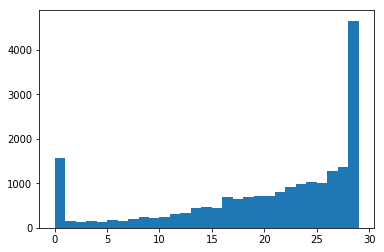

In [15]:
 plt.hist(listings_detail['availability_30'], bins = range(0, 30, 1))

In [16]:
# 找出其中的异常房源
not_bookable_30 = listings_detail[listings_detail["availability_30"] == 0]
print(not_bookable_30.shape)

(1578, 117)


In [17]:
# not_bookable_30[not_bookable_30["calendar_updated"] == 0].shape

In [18]:
# 如下所示，一些上白天前更新的明显不是最近这个月被预定的客户房源， 应该删除

In [19]:
# count_dic = not_bookable_30["calendar_updated"].value_counts()
# count_df = pd.DataFrame({"updated_day_ago": count_dic.index, "count": count_dic.values})
# count_df.sort_values(by = ["updated_day_ago"], ascending = True)

In [20]:
# min_val = min(not_bookable_30["number_of_reviews"])
# max_val = max(not_bookable_30["number_of_reviews"])
# plt.hist(not_bookable_30["number_of_reviews"], bins = range(0, 172, 2))
# print(min_val, max_val)

In [21]:
# 推测availability_30为0中有相当一部分为房东因事设置不可预定，
# 因此将此部分数据全部删去
# ！！！此中应该错失一部分抢手房源，但是数据量对于总体来说较小

In [22]:
print("Before drop, there are {} rows".format(listings_detail.shape[0]))
listings_detail = listings_detail[listings_detail["availability_30"]!= 0]
print("After drop, there are {} rows".format(listings_detail.shape[0]))

Before drop, there are 25830 rows
After drop, there are 24252 rows


(array([   0.,  152.,  132.,  144.,  137.,  180.,  157.,  187.,  237.,
         229.,  238.,  320.,  343.,  436.,  474.,  440.,  698.,  637.,
         686.,  707.,  710.,  805.,  917.,  981., 1022., 1016., 1277.,
        1375., 4650.]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]),
 <a list of 29 Patch objects>)

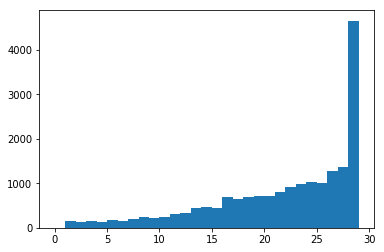

In [23]:
 plt.hist(listings_detail['availability_30'], bins = range(0, 30, 1))

### 开始分析

#### 基本信息

In [24]:
basic_col = ["id", "scrape_id", "last_scraped",
             "name", "summary", "description",
             "experiences_offered", "notes",
             "access", "interaction", "house_rules"]

In [25]:
listings_detail.shape

(24252, 117)

In [26]:
listings_detail[basic_col].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24252 entries, 0 to 28451
Data columns (total 11 columns):
id                     24252 non-null int64
scrape_id              24252 non-null int64
last_scraped           24252 non-null datetime64[ns]
name                   24251 non-null object
summary                21556 non-null object
description            22028 non-null object
experiences_offered    24252 non-null object
notes                  11462 non-null object
access                 12906 non-null object
interaction            13447 non-null object
house_rules            11798 non-null object
dtypes: datetime64[ns](1), int64(2), object(8)
memory usage: 2.2+ MB


In [27]:
listings_detail[basic_col].sample(1)

id       scrape_id last_scraped  \
6906  22299909  20190417125910   2019-04-17   

                                     name  \
6906  《游鱼之境》主题房/未来科学城/方正木屋落地大飘窗/大床房/北欧原木风   

                                                summary  \
6906  我的房源靠近优美的景色和公園｡因为人､氛围､户外空间,您一定会爱上我的房源｡我的房源适合情侣...   

                                            description experiences_offered  \
6906  我的房源靠近优美的景色和公園｡因为人､氛围､户外空间,您一定会爱上我的房源｡我的房源适合情侣...                none   

                                                  notes  \
6906  入住的客人有任何需要帮忙的地方,都可以给我们留言哦! 诸如你需要我们司机接送,在适当成本费用...   

                                                 access  \
6906  室内有热水器等酒店应该有的一切设备 我们一楼还有厨房可供选择使用 准确的讲,这是一个三层楼的...   

                                            interaction      house_rules  
6906  入住的客人有任何需要帮忙的地方,都可以给我们留言哦! 诸如你需要我们司机接送,在适当成本费用...  - 尽量安静不要太喧嚣是极好的

In [28]:
def plt_if_null(col):
    print(" ")
    print("current compare column ", col )
    group_1 = listings_detail[~ pd.isnull(listings_detail[col])]
    group_0 = listings_detail[pd.isnull(listings_detail[col])] 
    
    print("group 1 size: {}, group 0 size {}".format(group_1.shape[0], group_0.shape[0]))
    
    plt.figure(figsize = (7, 10))
    plt.subplot(2, 1, 1)
    plt.hist(group_1["availability_30"], label = "with_" + col)
    plt.hist(group_0["availability_30"], label = "no_" + col)
    plt.xlabel("availability_30")
    plt.ylabel("count_of_listings")
    plt.legend()
    
    plt.subplot(2, 1, 2)
    # box plot
    data = pd.DataFrame({"with_" + col: group_1["availability_30"],
                        "no_" + col: group_0["availability_30"]})
    data.boxplot()
    plt.show()
    print("-" * 57)
    print(" ")


 
current compare column  summary
group 1 size: 21556, group 0 size 2696


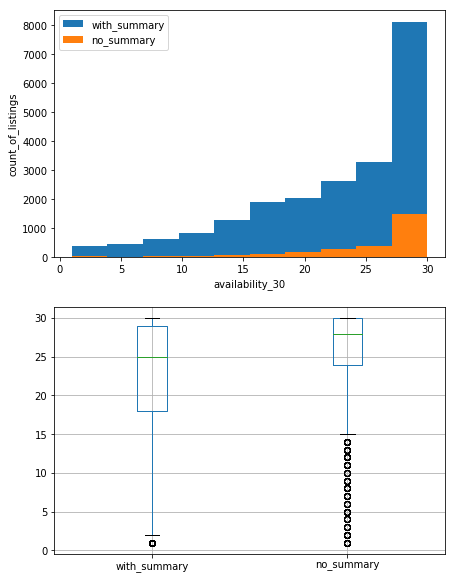

---------------------------------------------------------
 
 
current compare column  description
group 1 size: 22028, group 0 size 2224


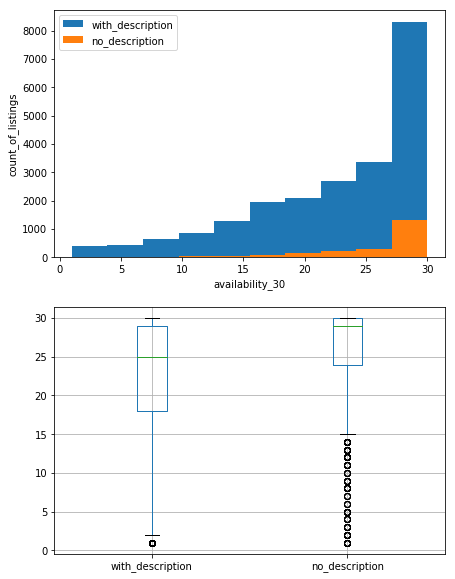

---------------------------------------------------------
 
 
current compare column  notes
group 1 size: 11462, group 0 size 12790


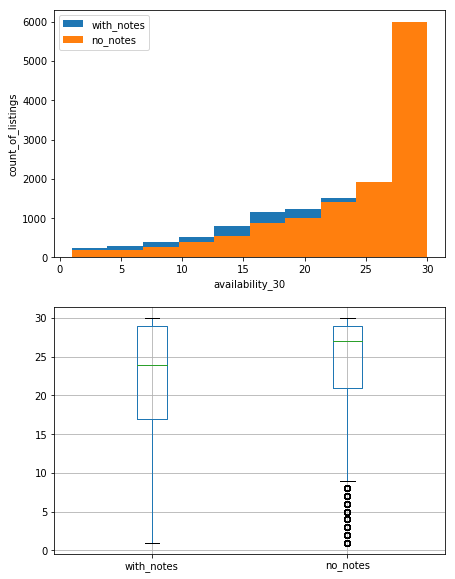

---------------------------------------------------------
 
 
current compare column  access
group 1 size: 12906, group 0 size 11346


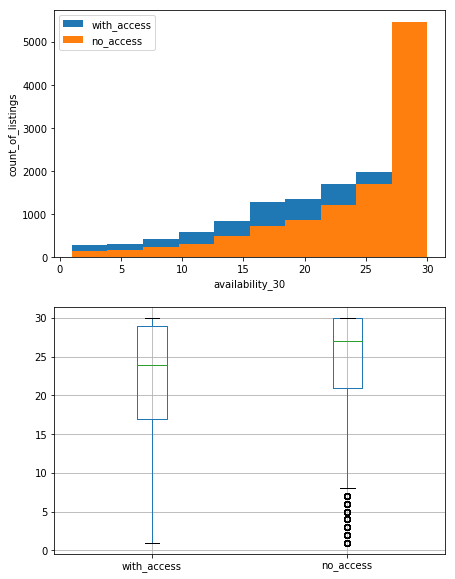

---------------------------------------------------------
 
 
current compare column  interaction
group 1 size: 13447, group 0 size 10805


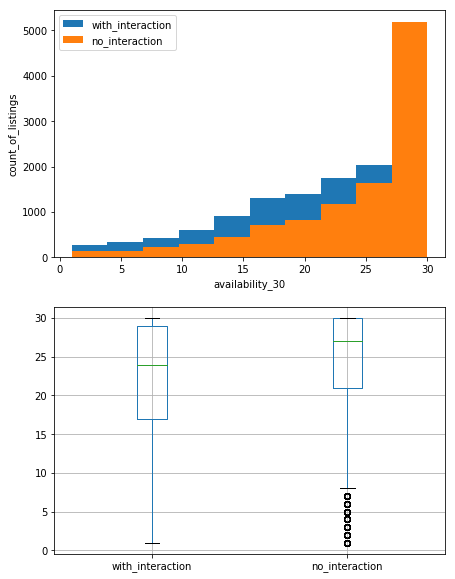

---------------------------------------------------------
 
 
current compare column  house_rules
group 1 size: 11798, group 0 size 12454


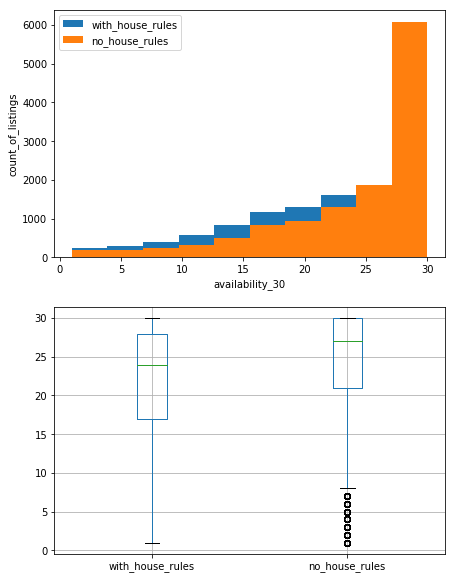

---------------------------------------------------------
 


In [29]:
for col in ["summary", "description", "notes", "access", "interaction", "house_rules" ]:
    plt_if_null(col)

#### 位置信息

In [30]:
location_col = ["space", "neighborhood_overview",
                "transit", "street", "neighbourhood",
                "neighbourhood_cleansed",
#                 "neighbourhood_group_cleansed",
                "city", "state", "zipcode", "market",
                "smart_location", "country_code",
                "country", "latitude", "longitude",
                "is_location_exact"]

In [31]:
listings_detail[location_col].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24252 entries, 0 to 28451
Data columns (total 16 columns):
space                     16328 non-null object
neighborhood_overview     15535 non-null object
transit                   15385 non-null object
street                    24252 non-null object
neighbourhood             17478 non-null object
neighbourhood_cleansed    24252 non-null object
city                      24195 non-null object
state                     24199 non-null object
zipcode                   15761 non-null float64
market                    24251 non-null object
smart_location            24252 non-null object
country_code              24252 non-null object
country                   24252 non-null object
latitude                  24252 non-null float64
longitude                 24252 non-null float64
is_location_exact         24252 non-null bool
dtypes: bool(1), float64(3), object(12)
memory usage: 3.0+ MB


In [32]:
listings_detail[location_col].sample(1)

space neighborhood_overview                       transit  \
6596   NaN                   NaN  出门30米有公交车站,小区内免费停车,也可停在自家窗户下   

                                street neighbourhood neighbourhood_cleansed  \
6596  Changping Qu, Beijing Shi, China           NaN                    昌平区   

              city        state   zipcode   market       smart_location  \
6596  Changping Qu  Beijing Shi  102202.0  Beijing  Changping Qu, China   

     country_code country  latitude  longitude  is_location_exact  
6596           CN   China  40.22841  116.23744              False

 
current compare column  space
group 1 size: 16328, group 0 size 7924


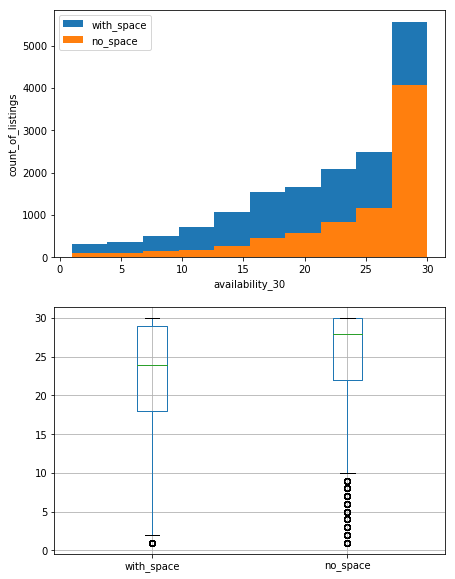

---------------------------------------------------------
 
 
current compare column  neighborhood_overview
group 1 size: 15535, group 0 size 8717


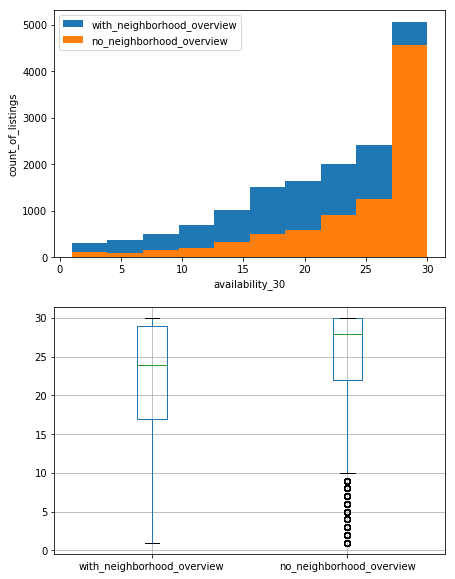

---------------------------------------------------------
 
 
current compare column  transit
group 1 size: 15385, group 0 size 8867


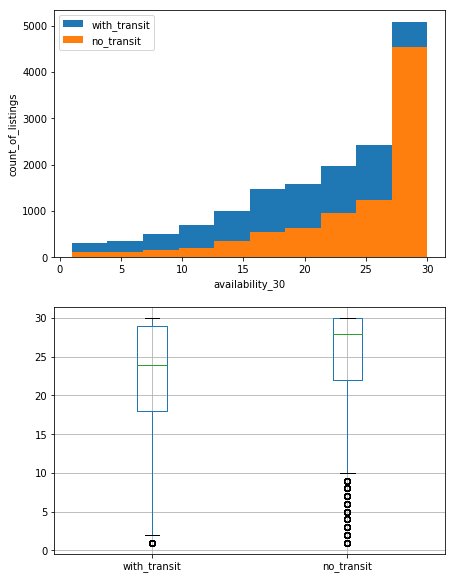

---------------------------------------------------------
 
 
current compare column  neighbourhood
group 1 size: 17478, group 0 size 6774


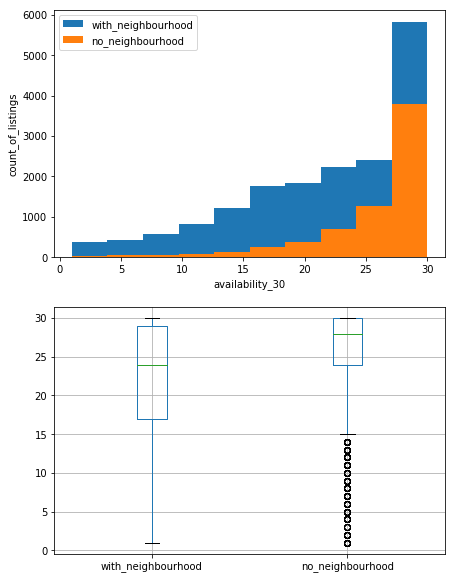

---------------------------------------------------------
 
 
current compare column  zipcode
group 1 size: 15761, group 0 size 8491


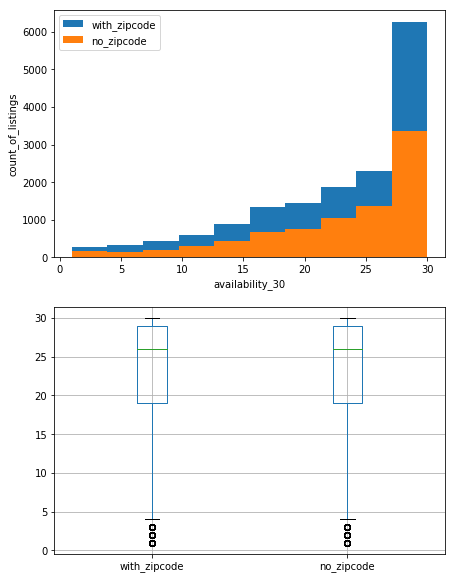

---------------------------------------------------------
 


In [33]:
for col in ["space", "neighborhood_overview", "transit","neighbourhood",
             "zipcode"]:
    plt_if_null(col)

In [34]:
loc_exact = listings_detail[listings_detail["is_location_exact"] == True]
loc_not_exact = listings_detail[listings_detail["is_location_exact"] == False]

In [35]:
loc_exact.shape, loc_not_exact.shape

((10333, 117), (13919, 117))

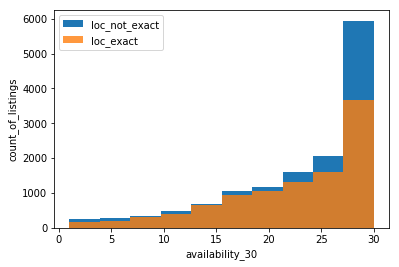

In [36]:
plt.hist(loc_not_exact["availability_30"], label = "loc_not_exact")
plt.hist(loc_exact["availability_30"], label = "loc_exact", alpha = 0.8)
plt.xlabel("availability_30")
plt.ylabel("count_of_listings")
plt.legend()

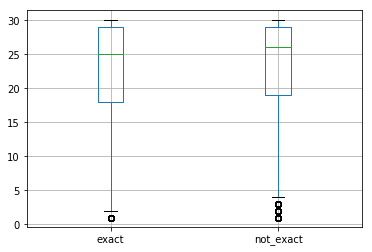

In [37]:
data = pd.DataFrame({"exact": loc_exact["availability_30"],\
                     "not_exact": loc_not_exact["availability_30"]})
data.boxplot()
plt.show()

In [38]:
set(list(listings_detail["neighbourhood_cleansed"]))

{'东城区',
 '丰台区 / Fengtai',
 '大兴区 / Daxing',
 '密云县 / Miyun',
 '平谷区 / Pinggu',
 '延庆县 / Yanqing',
 '怀柔区 / Huairou',
 '房山区',
 '昌平区',
 '朝阳区 / Chaoyang',
 '海淀区',
 '石景山区',
 '西城区',
 '通州区 / Tongzhou',
 '门头沟区 / Mentougou',
 '顺义区 / Shunyi'}

In [39]:
mean_res = listings_detail.groupby(["neighbourhood_cleansed"])["availability_30"].mean()
mean_res = pd.DataFrame( mean_res )
mean_res.columns = ["mean_val"]
# mean_res
mean_res.sort_values( by = "mean_val")

mean_val
neighbourhood_cleansed           
东城区                     18.498941
西城区                     20.254155
海淀区                     22.460670
朝阳区 / Chaoyang          22.924672
丰台区 / Fengtai           24.120915
石景山区                    24.826590
怀柔区 / Huairou           25.396641
昌平区                     25.427907
大兴区 / Daxing            25.570659
顺义区 / Shunyi            25.671037
房山区                     25.786765
延庆县 / Yanqing           26.253776
门头沟区 / Mentougou        26.425197
平谷区 / Pinggu            26.702479
通州区 / Tongzhou          26.906331
密云县 / Miyun             27.064368

In [40]:
med_res = listings_detail.groupby(["neighbourhood_cleansed"])["availability_30"].median()
med_res = pd.DataFrame( med_res )
med_res.columns = ["med"]
med_res.sort_values( by = ["med"], ascending = True)

med
neighbourhood_cleansed     
东城区                      19
西城区                      21
海淀区                      24
朝阳区 / Chaoyang           25
丰台区 / Fengtai            26
怀柔区 / Huairou            26
平谷区 / Pinggu             28
延庆县 / Yanqing            28
房山区                      28
昌平区                      28
石景山区                     28
顺义区 / Shunyi             28
大兴区 / Daxing             29
密云县 / Miyun              29
通州区 / Tongzhou           29
门头沟区 / Mentougou         29

In [41]:
# todo 地图上来画分布线: 等高线分析

#### 房东信息

In [42]:
host_col = ['host_id', 'host_url', 'host_name', 
            'host_since',
            'host_location',        # 先不考虑，太过杂乱 
            'host_about',           # 是否为null ？ -- 中英文? -- 字数？ 
            'host_response_time', 
            'host_response_rate', 
#             'host_acceptance_rate',
            'host_is_superhost',
            'host_thumbnail_url',
            'host_picture_url',
            'host_neighbourhood',    # 通常为比较知名的地点，如何使用
            'host_listings_count',   # 与host_total_listings_count相同
            'host_total_listings_count',
            'host_verifications',    # 一系列房东的确认方式 
            'host_has_profile_pic',  # 为 False 只有16个 
            'host_identity_verified']

In [147]:
print("There are {} host".format(len(set(list(listings_detail["host_id"])))))

There are 8725 host


In [65]:
# listings_detail['host_neighbourhood'].value_counts()

In [44]:
listings_detail[host_col].sample(1)

host_id                                     host_url host_name  \
17070  173744186  https://www.airbnb.com/users/show/173744186        藝薷   

      host_since host_location  \
17070 2018-02-16            CN   

                                              host_about host_response_time  \
17070  做为大学教师兼设计师,我和爱人一直寻找一些自己可以做的事情｡直到我发现,原来民宿是这样适合我...     within an hour   

       host_response_rate  host_is_superhost  \
17070                 1.0               True   

                                      host_thumbnail_url  \
17070  https://a0.muscache.com/im/pictures/user/f455f...   

                                        host_picture_url host_neighbourhood  \
17070  https://a0.muscache.com/im/pictures/user/f455f...      Foreign Trade   

       host_listings_count  host_total_listings_count  \
17070                    5                          5   

                 host_verifications  host_has_profile_pic  \
17070  [email, phone, zhima_selfie]                  True   

       host_identity_verified  
17070                   False

##### 创建feature

In [45]:
# create feature: host since year 
# host relative month: 2019-4-17 - since time

In [46]:
listings_detail["host_since_year"] = listings_detail["host_since"].map(lambda d: d.year)
listings_detail["host_duration"] = listings_detail["host_since"].map(lambda d: (datetime.datetime(2019, 4, 17) - d).days/30)

In [90]:
# 借助包来判别句子类型，主要是中文，英文，
# 可能中英文交杂，并不一定准确，观察可得很多判别为小语种的实则为中英文

def find_lang(sen):
    if pd.isnull(sen):
        return np.nan
    lan = langid.classify(sen)[0]
    return lan

listings_detail["host_about_lang"] = listings_detail["host_about"].map(lambda s: find_lang(s)) 

In [92]:
lang_count = listings_detail["host_about_lang"].value_counts()
lang_count.index

Index(['zh', 'en', 'la', 'ja', 'rw', 'mt', 'de', 'es', 'lb', 'it', 'fr', 'ro',
       'tr', 'da', 'no', 'et', 'sv', 'nl', 'qu', 'cs', 'ru', 'lv', 'sl', 'pt'],
      dtype='object')

In [98]:
# 查看各种语种的示例
for lang in lang_count.index:
    print("current language ", lang)
    print(listings_detail[listings_detail["host_about_lang"] == lang]["host_about"].sample(1))
    print(" ")

current language  zh
20271    我是90后阳光快乐的男孩,喜欢爬山,跑步,打乒乓球,喜欢周游中国吃遍各个区域美食特产,喜欢交...
Name: host_about, dtype: object
 
current language  en
7353    I was born in Peru, lived, worked, and studied...
Name: host_about, dtype: object
 
current language  la
1436    Hi,我我是一个乐观开朗的人,善于与人相处,具有亲和力,对待生活充满激情,｡我喜欢运动,卡通...
Name: host_about, dtype: object
 
current language  ja
12634    炒房团团员
Name: host_about, dtype: object
 
current language  rw
13823    yangwan
Name: host_about, dtype: object
 
current language  mt
5997    qijinjing1988
Name: host_about, dtype: object
 
current language  de
1286    A Note:Favorite Movie HOWARDS END
Name: host_about, dtype: object
 
current language  es
25230    Lunatics \n
Name: host_about, dtype: object
 
current language  lb
9557    我喜欢旅行,特别是自驾旅行,美食,音乐,不同地域文化｡\r\n\r\nIch spreche...
Name: host_about, dtype: object
 
current language  it
15836    Hello 
Name: host_about, dtype: object
 
current language  fr
18311    Viens de l'est
Name: host_about, dtype: object
 
curre

In [124]:
# feature 是一个离散型变量，而目标值/y值是一个连续型变量
# avaibility 值范围 range（0， 30， 1），可以认为这是一个离散值，也可以认为这是一个连续值
# 这里暂定认为这是一个连续值
def compare_categorical_feature(df, feat, y, feat_list = None):
    print(" ")
    print("current compare column ", feat )
    
    if feat_list is None:
        poss_feat = list(set(list(df[feat])))
    else:
        poss_feat = feat_list
    
    try:    
        poss_feat = sorted(poss_feat)
    except:
        pass
    
    group_list = []
    for f in poss_feat:
        group_list.append(df[df[feat] == f])
    
    for f, group in zip(poss_feat, group_list):
        print(" {}: {}, size: {}".format(feat, f, group.shape[0]))
    
    plt.figure(figsize = (7, 10))
    plt.subplot(2, 1, 1)
    for f, group in zip(poss_feat, group_list):
#         plt.hist(group[y], label = f)
        sns.kdeplot(df[df[feat] == f][y], shade = True, label = f, alpha = .5)
    plt.xlabel(y)
    plt.ylabel("probability")
    plt.legend()
    
    # box plot
    plt.subplot(2, 1, 2)
    data = pd.DataFrame({f: group[y] for f, group in zip(poss_feat, group_list)})
    data.boxplot()
    plt.xlabel(feat)
    plt.ylabel("nums")
    plt.show()
    print("-" * 57)
    print(" ")

In [99]:
host_categorical_col = ["host_since_year", 'host_response_time', "host_about_lang"]

In [68]:
host_continuous_col = ["host_duration", 
                       "host_response_rate",  
                       "host_listings_count"]

In [50]:
host_if_null_col = ["host_about", "host_neighbourhood"]

In [82]:
host_boolean_col = ["host_is_superhost", "host_identity_verified"]

#### 分析房东相关的离散型变量

 
current compare column  host_since_year
 host_since_year: 2015, size: 2243
 host_since_year: 2016, size: 4068
 host_since_year: 2017, size: 5822
 host_since_year: 2018, size: 8361


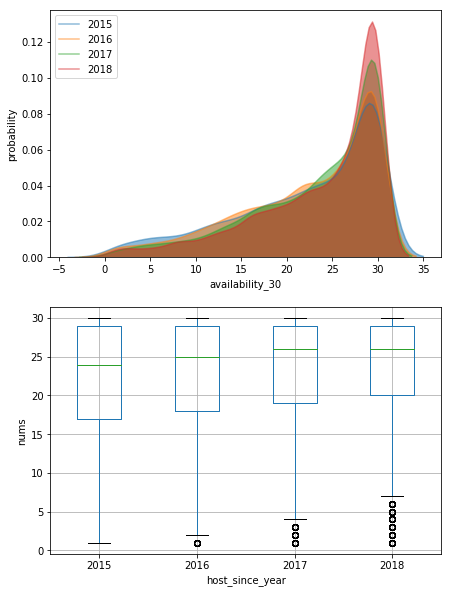

---------------------------------------------------------
 


In [122]:
compare_categorical_feature(df = listings_detail,
                            feat = "host_since_year", 
                            y = "availability_30",
                            feat_list = [2015, 2016, 2017, 2018]
                           )

In [127]:
set(list(listings_detail["host_response_time"]))

{'a few days or more',
 nan,
 'within a day',
 'within a few hours',
 'within an hour'}

 
current compare column  host_response_time
 host_response_time: a few days or more, size: 604
 host_response_time: within a day, size: 919
 host_response_time: within a few hours, size: 1503
 host_response_time: within an hour, size: 19369


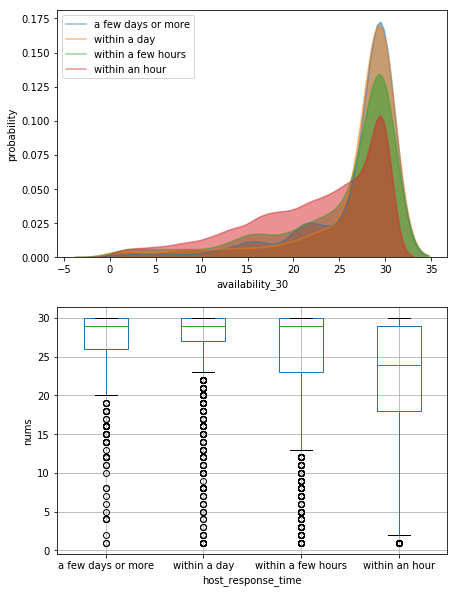

---------------------------------------------------------
 


In [129]:
compare_categorical_feature(df = listings_detail,
                            feat = "host_response_time", 
                            y = "availability_30",
                            feat_list = ['within an hour',
                                         'within a few hours',
                                         'within a day',
                                         'a few days or more'],
                           )

 
current compare column  host_about_lang
 host_about_lang: en, size: 1238
 host_about_lang: zh, size: 13818


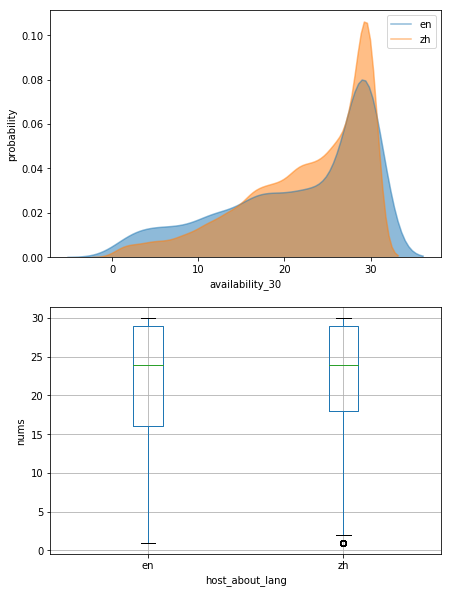

---------------------------------------------------------
 


In [132]:
compare_categorical_feature(df = listings_detail,
                            feat = "host_about_lang", 
                            y = "availability_30",
                            feat_list = ["en", "zh"]
                           )

#### 连续值特征。。

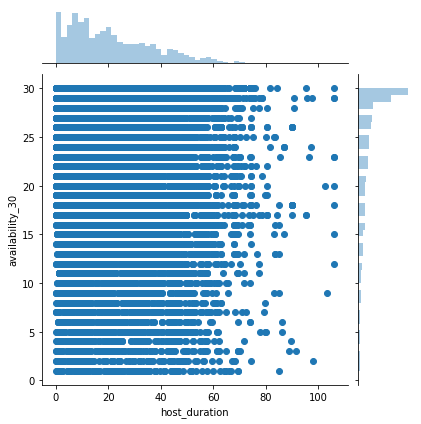

In [135]:
# plt.scatter(listings_detail["host_duration"], listings_detail["availability_30"])
sns.jointplot("host_duration", "availability_30", listings_detail)

#### 是否为null 的影响

 
current compare column  host_about
group 1 size: 15196, group 0 size 9056


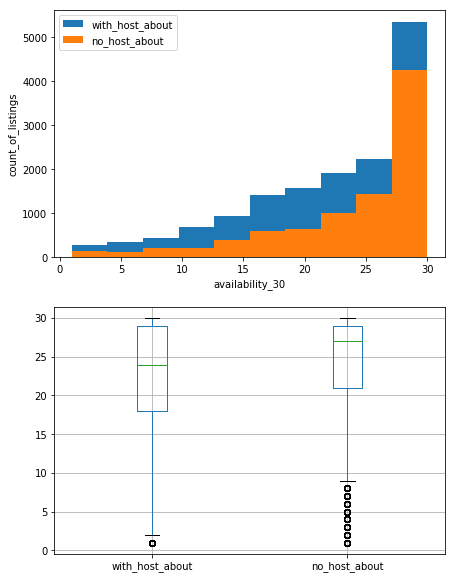

---------------------------------------------------------
 


In [136]:
plt_if_null(col = "host_about")

 
current compare column  host_neighbourhood
group 1 size: 13714, group 0 size 10538


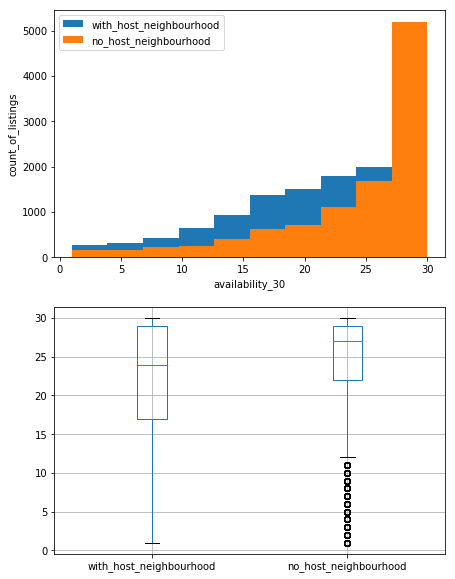

---------------------------------------------------------
 


In [137]:
plt_if_null( col = "host_neighbourhood")

判断是boolean值

In [144]:
def compare_boolean_value(df, feat, y):
    df[feat] == True
    true_g = df[df[feat] == True]
    false_g = df[df[feat] == False]
    
    print("Value: True, size: {}".format(true_g.shape[0]))
    print("Value: False, size: {}".format(false_g.shape[0]))
    
    plt.figure(figsize = (7, 10))
    plt.subplot(2, 1, 1)
    sns.kdeplot(true_g[y], shade = True, label = "True", alpha = .5)
    sns.kdeplot(false_g[y], shade = True, label = "False", alpha = .5)
    plt.xlabel(y)
    plt.ylabel("probability")
    plt.legend()
    
    # box plot
    plt.subplot(2, 1, 2)
    data = pd.DataFrame({"True": df[df[feat] == True][y],
                         "False": df[df[feat] == False][y] })
    data.boxplot()
    plt.xlabel(feat)
    plt.ylabel("nums")
    plt.show()

In [140]:
listings_detail["host_is_superhost"].sample(10)

17913    False
5555     False
7066     False
3028     False
25176    False
17916    False
10170    False
5886     False
3187      True
26285    False
Name: host_is_superhost, dtype: bool

Value: True, size: 4761
Value: False, size: 19491


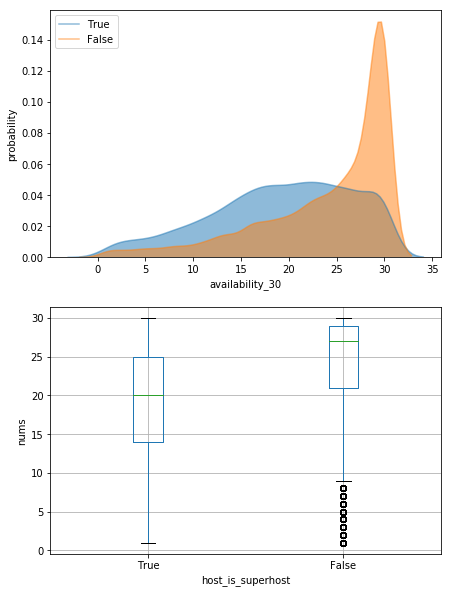

In [145]:
compare_boolean_value(df = listings_detail,
                      feat = "host_is_superhost",
                      y = "availability_30")

Value: True, size: 4181
Value: False, size: 20071


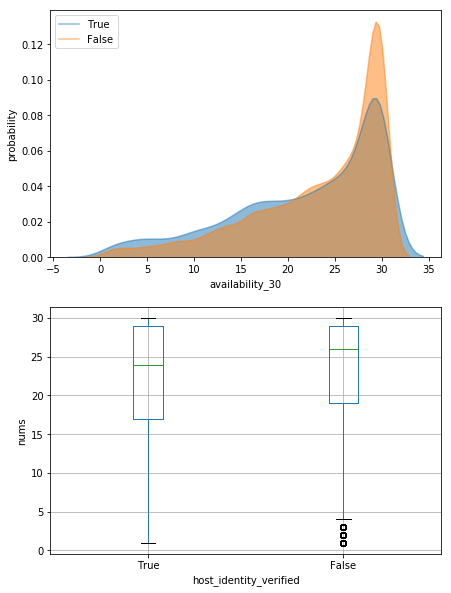

In [146]:
compare_boolean_value(df = listings_detail,
                      feat = "host_identity_verified",
                      y = "availability_30")

#### 关于房屋的设备

In [149]:
equip_col = ["property_type", "room_type",
             "accommodates", "bathrooms", "bedrooms",
             "beds", "bed_type", "amenities", "square_feet"]

In [152]:
listings_detail["property_type"].value_counts()

Apartment                 8734
House                     4388
Condominium               4045
Loft                      1659
Serviced apartment        1316
Bungalow                   739
Farm stay                  559
Villa                      527
Townhouse                  324
Boutique hotel             274
Guest suite                233
Bed and breakfast          224
Guesthouse                 207
Hostel                     165
Cottage                    125
Nature lodge               112
Castle                      92
Resort                      85
Other                       72
Aparthotel                  59
Tiny house                  48
Hotel                       44
Cabin                       37
Camper/RV                   31
Minsu (Taiwan)              28
Earth house                 24
Chalet                      22
Tent                        14
Hut                         13
Barn                        10
Campsite                    10
Cave                         6
Pension 

 
current compare column  property_type
 property_type: Apartment, size: 8734
 property_type: Condominium, size: 4045
 property_type: House, size: 4388
 property_type: Loft, size: 1659
 property_type: Serviced apartment, size: 1316


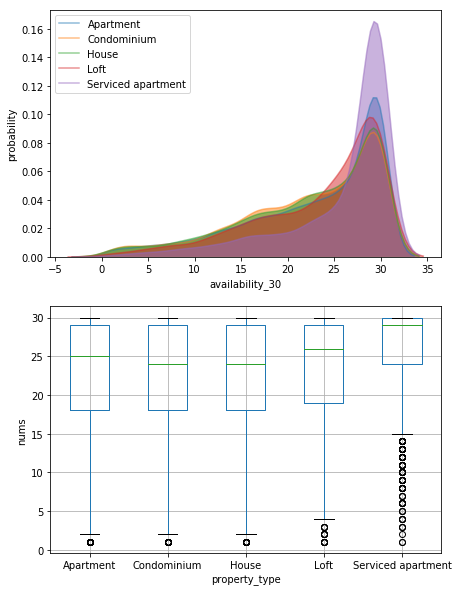

---------------------------------------------------------
 


In [166]:
compare_categorical_feature(df = listings_detail,
                            feat = "property_type", 
                            y = "availability_30",
                            feat_list = ["Apartment", "Condominium",
                                         "House", "Loft", "Serviced apartment"]
                           )

In [153]:
listings_detail["room_type"].value_counts()

Entire home/apt    14858
Private room        8007
Shared room         1387
Name: room_type, dtype: int64

 
current compare column  room_type
 room_type: Entire home/apt, size: 14858
 room_type: Private room, size: 8007
 room_type: Shared room, size: 1387


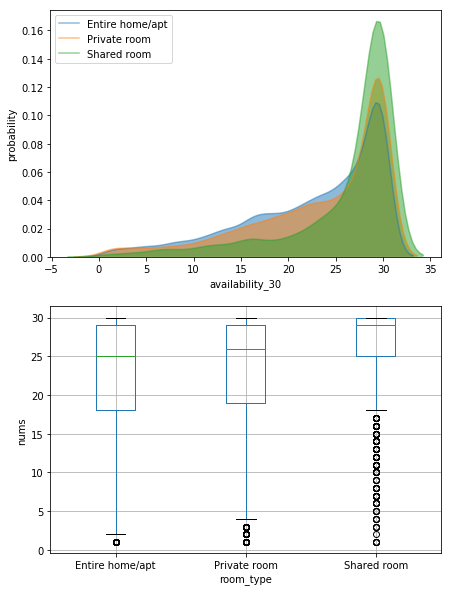

---------------------------------------------------------
 


In [164]:
compare_categorical_feature(df = listings_detail,
                            feat = "room_type", 
                            y = "availability_30",
                            feat_list = None
                           )

In [155]:
listings_detail["accommodates"].value_counts()

2     10503
4      4732
3      2099
1      2085
6      1655
5      1014
8       549
16      488
7       319
10      254
12      209
9       117
15       75
14       65
13       44
11       44
Name: accommodates, dtype: int64

 
current compare column  accommodates
 accommodates: 1, size: 2085
 accommodates: 2, size: 10503
 accommodates: 3, size: 2099
 accommodates: 4, size: 4732
 accommodates: 5, size: 1014
 accommodates: 6, size: 1655


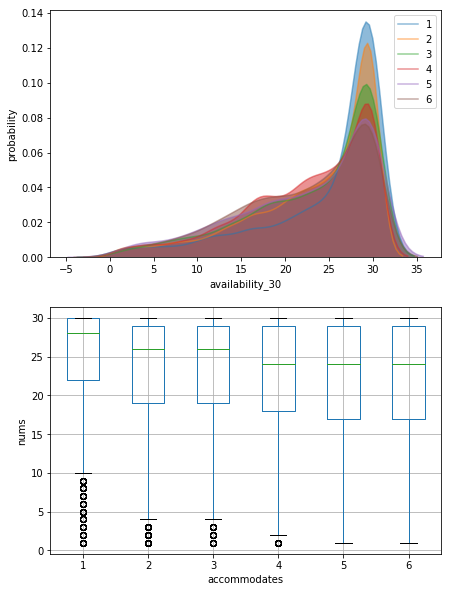

---------------------------------------------------------
 


In [163]:
compare_categorical_feature(df = listings_detail,
                            feat = "accommodates", 
                            y = "availability_30",
                            feat_list = [1, 2, 3, 4, 5, 6]
                           ) 

In [160]:
listings_detail["bed_type"].value_counts()

Real Bed         24175
Futon               30
Pull-out Sofa       24
Couch               14
Airbed               9
Name: bed_type, dtype: int64

 
current compare column  bed_type
 bed_type: Airbed, size: 9
 bed_type: Couch, size: 14
 bed_type: Futon, size: 30
 bed_type: Pull-out Sofa, size: 24
 bed_type: Real Bed, size: 24175


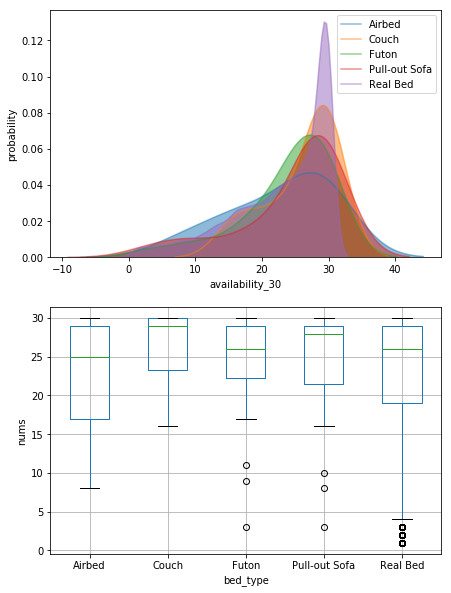

---------------------------------------------------------
 


In [161]:
compare_categorical_feature(df = listings_detail,
                            feat = "bed_type", 
                            y = "availability_30",
                            feat_list = None
                           )

#### 价格影响b

In [168]:
# 关于美元的实时汇率 -- 影响房价的人民币价格 ？ 出租情况的相关性
price_col = ["price", "weekly_price", "monthly_price",
            "security_deposit", "cleaning_fee"]

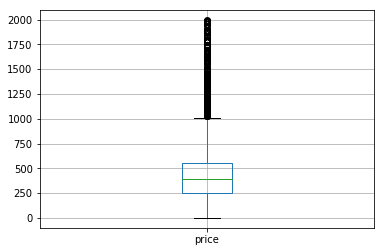

In [174]:
tmp_df = listings_detail[listings_detail["price"]< 2000]
tmp_df.boxplot(column = "price")

In [175]:
listings_detail["availability_30"].value_counts()

30    4965
29    3239
28    1411
27    1375
26    1277
24    1022
25    1016
23     981
22     917
21     805
20     710
19     707
16     698
18     686
17     637
14     474
15     440
13     436
12     343
11     320
10     238
8      237
9      229
7      187
5      180
6      157
1      152
3      144
4      137
2      132
Name: availability_30, dtype: int64

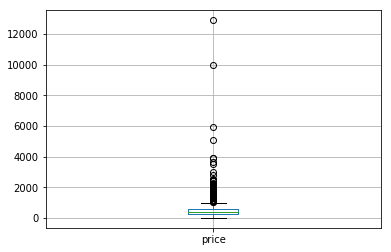

In [184]:
tmp_df = listings_detail[listings_detail["availability_30"] < 10]
tmp_df.boxplot(column = "price")

In [185]:
sample = listings_detail[(listings_detail["price"] > 12000) & (listings_detail["availability_30"] < 10)]

In [186]:
for item in sample:
    print(item, sample[item])

id 13152    27279622
Name: id, dtype: int64
listing_url 13152    https://www.airbnb.com/rooms/27279622
Name: listing_url, dtype: object
scrape_id 13152    20190417125910
Name: scrape_id, dtype: int64
last_scraped 13152   2019-04-17
Name: last_scraped, dtype: datetime64[ns]
name 13152    【京遇】老北京城胡同大气独门四合院!前法国领事住宅!近雍和宫/南锣鼓巷/后海/国子监/簋街/故宫
Name: name, dtype: object
summary 13152    【坐标】雍和宫/国子监/簋街/后海/南锣鼓巷/故宫/王府 (Website hidden b...
Name: summary, dtype: object
space 13152    我家房屋属于北京的传统胡同建筑,砖木结构,青砖青瓦,自成一体｡配有全屋地暖和中央空调,完全满...
Name: space, dtype: object
description 13152    【坐标】雍和宫/国子监/簋街/后海/南锣鼓巷/故宫/王府 (Website hidden b...
Name: description, dtype: object
experiences_offered 13152    none
Name: experiences_offered, dtype: object
neighborhood_overview 13152    房屋靠近北京有名的美食街-簋街,晚上热闹非凡,美食遍布｡但胡同内传统市井,晚上异常安静,且独...
Name: neighborhood_overview, dtype: object
notes 13152    NaN
Name: notes, dtype: object
transit 13152    房屋靠近五号线地铁站-北新桥站,便于到达北京城绝大多数著名景点,步行约5-10分钟｡出行打车...
Name: transit, dtype: object
acce

(array([ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  3.,  2.,  1.,
         1.,  2., 13.]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]),
 <a list of 29 Patch objects>)

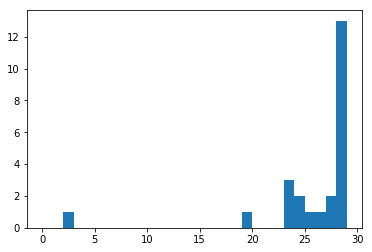

In [191]:
tmp_df = listings_detail[listings_detail["price"] > 10000]
plt.hist(tmp_df["availability_30"], bins = range(0, 30, 1))

 
current compare column  weekly_price
group 1 size: 301, group 0 size 23951


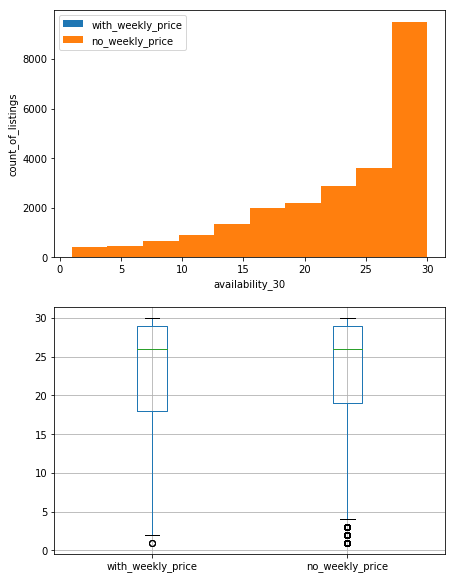

---------------------------------------------------------
 


In [192]:
plt_if_null(col = "weekly_price")

 
current compare column  monthly_price
group 1 size: 312, group 0 size 23940


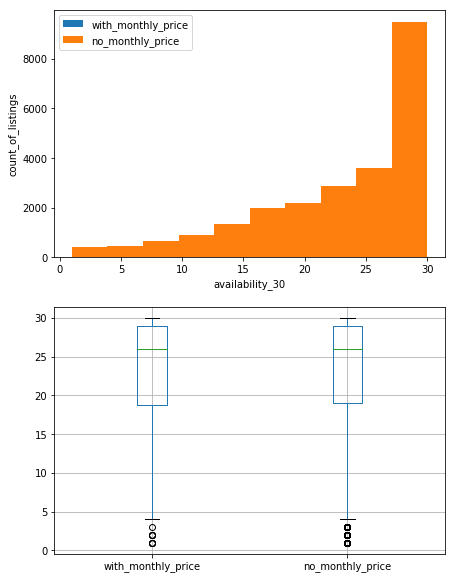

---------------------------------------------------------
 


In [193]:
plt_if_null(col = "monthly_price")

####  关于评价

(array([2.2829e+04, 9.6800e+02, 2.7000e+02, 1.0300e+02, 4.9000e+01,
        1.9000e+01, 9.0000e+00, 1.0000e+00, 3.0000e+00, 1.0000e+00]),
 array([  0. ,  32.2,  64.4,  96.6, 128.8, 161. , 193.2, 225.4, 257.6,
        289.8, 322. ]),
 <a list of 10 Patch objects>)

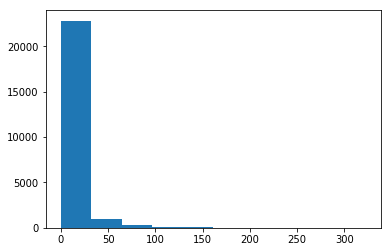

In [197]:
plt.hist(listings_detail["number_of_reviews"])